This notebook will create sets of potentials to run simulations with.

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import MagicTools as mt
import itertools as it
from scipy.signal import savgol_filter
import string

## Creating the Potentials

Each potential will be a numpy array consisting of 300 points.

In order to be physical, for short distances (small r) the value of the potential needs to be very high (forbidden region), and need to go to zero for large r.

In [2]:
random.seed(1)

In [3]:
def getforbid(N, mean, SD):
    forbid = random.gauss(mean, SD)
    forbid = int(round(forbid, 0))
    if forbid > 0 and forbid < N:
        return forbid
    else:
        return getforbid(N, mean, SD)
        
#this function generates the size of the forbidden reason randomly for a potential of length N,
#according to a gaussian distribution centred at mean with s.d. SD
#output cannot be negative or larger than N

In [8]:
def create_potential(N, mean, SD):
    pot = np.zeros(N)
    forbid = getforbid(N, mean, SD)
    
    for i in range(forbid):
        pot[i] = 75000 - 50*i

    non_forbid = np.zeros(N - forbid)
    non_forbid[0] = random.gauss(0, 2.5)
    i = 1
    while i < len(non_forbid):
        non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, .5)
        i = i + 1

    non_forbid_smooth = savgol_filter(non_forbid, 31, 3)
    
    while max(non_forbid_smooth) - min(non_forbid_smooth) > 15:
        non_forbid_smooth = 0.9*non_forbid_smooth
    
    for i in range(len(non_forbid_smooth)):
        pot[forbid + i] = non_forbid_smooth[i]

    shift = pot[len(pot) - 1]
    pot = pot - shift
    
    return pot

#this function creates a random potential of length N
#forbidden region size determined by Gaussian with mean mean and standard deviation SD
#the potential is smoothed using a savgol filter

In [19]:
potentials = []
while len(potentials) < 1000000:
    pot = create_potential(300, 60, 25)
    potentials.append(pot)
    
#potentials is a list where each object in the list is a numpy array containing 300 values representing a potential

## Writing Potentials to LAMMPS Files

Using MagicTools:

In [15]:
alphabet_list = list(string.ascii_uppercase)
all_atoms_seperate = list(it.product(alphabet_list, repeat = 2))
all_atoms = []
for i in range(len(all_atoms_seperate)):
    atom = all_atoms_seperate[i][0] + all_atoms_seperate[i][1]
    all_atoms.append(atom)
    
#all_atoms is a list which contains all possible two letter combinations, which is the list which will be used
#for the bead names

In [16]:
def write_potential(filename, n):
    N = int(n)
    N_NB = int(N*(N+1)/2) #number of non-bonded interactions
    N_B = int(0) #number of bonded interactions
    N_A = int(0) #number of angle interactions

    Min = 0  
    Max = 15 #range of r for potentials

    NPoints = int(300) #Number of points in each potential

    stepsize = (Max-Min)/NPoints #the distance between points
    rvalues = np.linspace(Min + stepsize/2, Max - stepsize/2, NPoints) #an array containg the r values

    AtomList = []
    for i in range(N):
        AtomList.append(all_atoms[i])
        
    AtomPairs = list(it.combinations_with_replacement(AtomList, r = 2)) #all possible atoms pairs, no repeats
    
    
    
    general_section = " &General \n" + " NTypes= {} \n".format(N) + " N_NB= {} \n".format(N_NB) + \
    " N_B= {} \n".format(N_B) + " N_A= {} \n".format(N_A)+ " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + \
    " NPoints= {} \n".format(NPoints) + " &EndGeneral \n"
    
    potential_section = ''
    for i in range(len(AtomPairs)):
        single_pot = potentials[random.randint(0, len(potentials)-1)]
        header_section = " &Potential \n" + " Name= {}-{} \n".format(AtomPairs[i][0], AtomPairs[i][1]) + \
        " Type = NB \n" \
        + " Min= {} \n".format(Min) + " Max= {} \n".format(Max) + " NPoints= {} \n".format(NPoints) + \
        " AtomTypes= {},{} \n".format(AtomPairs[i][0], AtomPairs[i][1])
        
        table_section = ' &Table \n'
        for j in range(NPoints):
            rval = format(rvalues[j], '.7f')
            potval = format(single_pot[j], '.7f')
            table_section = table_section + "     " + str(rval) + "  " + str(potval) + " \n"
            
        table_section = table_section + " &EndTable \n" + " &EndPotential \n"
        
        potential_section = potential_section + header_section + table_section
        
    potfile = open('{}.pot'.format(filename), 'w')
    potfile.write(general_section)
    potfile.write(potential_section)
    potfile.close()
    
#write potentials is a function which writes a magic potential file
#the first argument is the filename, output will be <filename.pot>
#the second argument (N) is th number of bead types
#the potentials are randomly selected from the list potentials

In [17]:
def create_files(BeadRange, number):
    for BeadNumber in range(1, BeadRange+1):
        for j in range(number):
            write_potential('MagiC_Potentials/{}beadpotential{}'.format(BeadNumber, j), BeadNumber)
            pot = mt.ReadPot('MagiC_Potentials/{}beadpotential{}.pot'.format(BeadNumber, j), quiet = True)
            mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
                          npoints = 2500, Umax = 6000.0, \
                          interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
                          filename = 'LAMMPS_Potentials/{}beadpotential{}'.format(BeadNumber, j))

#this function creates magic and LAMMPS potential files for 1, 2, ..., BeadRange number of beads
#the second argument determines how many files are created for each bead number

In [20]:
create_files(1, 10000)

In [10]:
create_files(2, 2)

In [11]:
#pot = mt.ReadPot('MagiC_Potentials/1beadpotential3.pot', quiet = True)
#mt.PotsExport(pot, MDEngine = 'LAMMPS', Rmaxtable = 15.5, PHImaxtable = 180.0, \
#                          npoints = 2500, Umax = 6000.0, \
#                          interpol = True, method = 'gauss', sigma = 0.5, noplot=True, hardcopy = False, \
#                          filename = '1bead')

In [6]:
x = np.linspace(0,15,300)


(-15.0, 15.0)

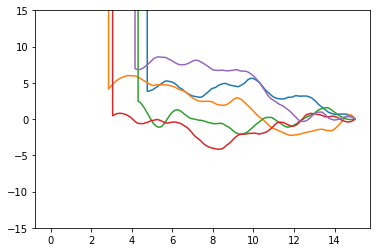

In [14]:
x = np.linspace(0,15,300)

for i in range(5):
    plt.plot(x, potentials[random.randint(0,len(potentials))])

plt.ylim(-15,15)

In [22]:
N = 300
pot = [1]

pot3 = np.zeros(300)
pot5 = np.zeros(300)
pot7 = np.zeros(300)
forbid = getforbid(300, 60, 25)
    
for i in range(forbid):
    pot3[i] = 75000 - 50*i
    pot5[i] = 75000 - 50*i
    pot7[i] = 75000 - 50*i

non_forbid = np.zeros(N - forbid)
non_forbid[0] = random.gauss(0, 2.5)
i = 1
while i < len(non_forbid):
    non_forbid[i] = non_forbid[i - 1] + random.random() * random.gauss(0, 1)
    i = i + 1

non_forbid_smooth3 = savgol_filter(non_forbid, 3, 2)
non_forbid_smooth5 = savgol_filter(non_forbid, 5, 2)
non_forbid_smooth7 = savgol_filter(non_forbid, 7, 2)
    
while max(non_forbid_smooth3) - min(non_forbid_smooth3) > 15:
    non_forbid_smooth3 = 0.9*non_forbid_smooth3
    
while max(non_forbid_smooth5) - min(non_forbid_smooth5) > 15:
    non_forbid_smooth5 = 0.9*non_forbid_smooth5
    
while max(non_forbid_smooth7) - min(non_forbid_smooth7) > 15:
    non_forbid_smooth7 = 0.9*non_forbid_smooth7
    
for i in range(len(non_forbid_smooth3)):
    pot3[forbid + i] = non_forbid_smooth3[i]
    pot5[forbid + i] = non_forbid_smooth5[i]
    pot7[forbid + i] = non_forbid_smooth7[i]

#shift = pot[len(pot) - 1]
#pot = pot - shift
#if shift > 10:
#    pot = pot * 0.5
    


#this function creates a random potential of length N
#forbidden region size determined by Gaussian with mean mean and standard deviation SD
#the potential is smoothed using a savgol filter

(-5.0, 5.0)

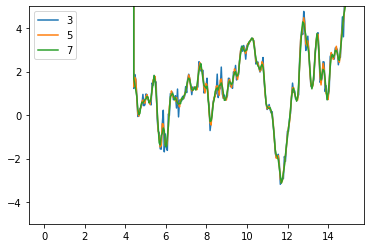

In [24]:
plt.plot(x, pot3, label = '3')
plt.plot(x, pot5, label = '5')
plt.plot(x, pot7, label = '7')
plt.legend()
plt.ylim(-5,5)